In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

#import libraries
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable, variable
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import math
import matplotlib.pyplot as plt
import csv
from scipy.special import inv_boxcox
import numpy as np
import seaborn as sns
from matplotlib.animation import FuncAnimation
import random
from captum.attr import IntegratedGradients
import statsmodels.api as sm
import pandas as pd
import itertools
from patsy import dmatrices
import os

C:\ProgramData\miniconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
#set device to use gpu
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
#Hyperparameters
hyper_params={
    "n_epochs" : 30, 
    "input_size" : 6,
    "sequence_length" : 92,
    "batch_size" : 1000,
    "num_layers" : 2,
    "hidden_size" : 128,
    "alpha" : 0.007,
    "dropout": 0.05
}
#set seed to allow for reporducibility
# os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:2"
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Import data
#set device
device = torch.device('cpu')

#Import data
Raw_data = pd.read_csv("../Data/Raw_data.csv",index_col=0)
Training_df = pd.read_csv("../Data/Train.csv",index_col=0)
Val_df = pd.read_csv("../Data/Val.csv",index_col=0)
Test_df = pd.read_csv("../Data/Test.csv",index_col=0)

#Import data required to undo normalization
#import the list of min_maxs for normalization
min_max= []
with open('../Data/Min_max.txt', 'r') as file:
    contents = file.readlines()
    for i in contents:
        i.strip("''")
        line = i[1:-3].split(",")
        min_max.append(list(line))
for i in range(len(min_max)):
    for j in range(len(min_max[i])):
        if j >= 1:
            min_max[i][j] = float(min_max[i][j])
        else:
            min_max[i][j] = min_max[i][j].strip("'")
            
#import the list of lambdas
lambda_list = []
with open('../Data/Lambda.txt', 'r') as file:
    contents = file.readlines()
    for i in contents:
        i.strip("''")
        line = i[1:-3].split(",")
        lambda_list.append(list(line))
for i in range(len(lambda_list)):
    for j in range(len(lambda_list[i])):
        if j >= 1:
            lambda_list[i][j] = float(lambda_list[i][j])
        else:
            lambda_list[i][j] = lambda_list[i][j].strip("'")

#Import Trend Data
Trend = pd.read_csv("../Data/Trend.csv",index_col=0)

#Prepare Validation and Test dataset
#Add the last 92 entries from Training to Validation. 
Val_df2 = Training_df.iloc[-(hyper_params['sequence_length']+7):,:]._append(Val_df)

#Add the last 92 entries from Validation to Test. 
Test_df2 = Val_df.iloc[-(hyper_params['sequence_length']+7):,:]._append(Test_df)


In [3]:
#Prepare training data into data loader
class Sequential_Data(Dataset):
    def __init__(self, data, window):
        self.data = torch.Tensor(data.values)
        self.window = window
        self.shape = self.__getshape__()
        self.size = self.__getsize__()
 
    def __getitem__(self, index):
        x = self.data[index:index+self.window]
        y = self.data[index+6+self.window,3]
        return x, y
 
    def __len__(self):
        return len(self.data) -  self.window -7
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape)
    
    def __getsize__(self):
        return (self.__len__())

#Load in data
Training_data = Sequential_Data(Training_df,hyper_params['sequence_length'])
Validation_data = Sequential_Data(Val_df2,hyper_params['sequence_length'])
Test_data = Sequential_Data(Test_df2,hyper_params['sequence_length'])


# Load into a data loader 
trainloader = DataLoader(dataset=Training_data,batch_size=hyper_params['batch_size'],shuffle=False,num_workers=0)
valloader = DataLoader(dataset=Validation_data,batch_size=hyper_params['batch_size'],shuffle=False,num_workers=0)


In [4]:
#SMAPE 
#Calculate accuracy of using the symmetric mean absolute percentage error
def SMAPE(Predicted, Actual):
    try:
        n= len(Predicted)
    except:
        n= 1
    numer = abs(Predicted-Actual)
    denom = (abs(Actual) + abs(Predicted))*0.5
    return (100/n) * (np.sum(numer/denom))

def to_raw(Results,Data):
    if type(Results) == torch.Tensor:
        x = np.array(Results.cpu().detach())
    else :
        x = np.array(Results.cpu())
    Un_normal = (x*(min_max[3][2]-min_max[3][1])) + min_max[3][1]
    
    if Data=="Val":
        Seasonal = Un_normal + np.array(Trend.iloc[-400:-200,3])
    elif Data == "Test": 
        Seasonal = Un_normal + np.array(Trend.iloc[-200:,3])
    else:
        Seasonal = Un_normal + np.array(Trend.iloc[hyper_params['sequence_length']+5:-401,3])
    
    Non_box_cox = inv_boxcox(Seasonal,lambda_list[3][1])
    return Non_box_cox


In [5]:
#Define LSTM model
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,drop_p):
        super(LSTM,self).__init__()
        #stipulate number of layers and hidden layer size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.drop_p = drop_p
        
        #Layer
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True,dropout=drop_p)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        #fully connect layer
        self.fc = nn.Linear(in_features=hidden_size,out_features=1)
        #input = [batch_size,number_in_seq,num_features]
    
    def forward(self,x):
        #initialise hidden and cell state
        h0 = Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device))
        c0 = Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device))
        # h_initial = [number_of_layers,bath_size,hidden_size] -> [1,100,128]
        #Proporgate
        output, (hn, cn) = self.lstm(x,(h0,c0))
        
        #retrieve last hidden state:
        last_out = output[:,-1,:] #[n,128]
        
        #add non-linearity
        #non_linear = self.sig(last_out)
        non_linear = self.relu(last_out)

        #collapse the output to a prediction
        prediction = self.fc(non_linear)
        #reshape the output 
        prediction = torch.reshape(prediction,(last_out.size()[0],))
        return prediction


In [6]:
model = LSTM(input_size=hyper_params['input_size'],
                                    hidden_size=hyper_params['hidden_size'],
                                    num_layers=hyper_params['num_layers'],
                                    drop_p=hyper_params['dropout']).to(device)

criterion = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(),lr=hyper_params['alpha'])
model = LSTM(input_size=hyper_params['input_size'],
                                    hidden_size=hyper_params['hidden_size'],
                                    num_layers=hyper_params['num_layers'],
                                    drop_p=hyper_params['dropout']).to(device)

model.eval()


LSTM(
  (lstm): LSTM(6, 128, num_layers=2, batch_first=True, dropout=0.05)
  (relu): ReLU()
  (sig): Sigmoid()
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [13]:
#Determine accuracy for each dataset
trainloader = DataLoader(dataset=Training_data,batch_size=len(Training_data),shuffle=False,num_workers=0)
valloader = DataLoader(dataset=Validation_data,batch_size=len(Validation_data),shuffle=False,num_workers=0)
testloader = DataLoader(dataset=Test_data,batch_size=len(Test_data),shuffle=False,num_workers=0)

for j, (test_sequence, test_forecast) in enumerate(testloader): 
    test_sequence = Variable(test_sequence).to(device)
    test_forecast = Variable(test_forecast).to(device)
    
    Test_out = model(test_sequence)
    Predicted = to_raw(Results=Test_out, Data= "Test")


In [15]:
Predicted.shape

(200,)

In [8]:
#Make predictions for test dataset. This will be used as the benchmark
for i, (test_sequence, test_forecast) in enumerate(testloader): 
    test_sequence = Variable(test_sequence).to(device)
    test_forecast = Variable(test_forecast).to(device)

    Test_out = model(test_sequence)
    Predicted = to_raw(Results=Test_out, Data= "Test")


In [9]:
class Permuted_Data(Dataset):
    def __init__(self, Original_Data, Permuted_data, window):
        self.Pdata = torch.Tensor(Permuted_data.values)
        self.Odata= torch.Tensor(Original_Data.values)
        self.window = window
        self.shape = self.__getshape__()
        self.size = self.__getsize__()
 
    def __getitem__(self, index):
        x = self.Pdata[index:index+self.window]
        y = self.Odata[index+6+self.window,3]
        return x, y
 
    def __len__(self):
        return len(self.Pdata) -  self.window -7
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape)
    
    def __getsize__(self):
        return (self.__len__())

In [29]:
#Permutation
#Define function to permute datasets
def Permute(DF,Feature,Start=1,End=298):
    COPY = DF.copy()
    for i in np.arange(End,Start,-1):
        rs =random.sample(range(i),1)
        if Feature == 6:
            COPY.iloc[i,:] = DF.iloc[rs,:]
        else:
            print("non target column")
            COPY.iloc[i,Feature] = DF.iloc[rs,Feature]
    
    return COPY   



In [23]:
#create combinations of permuted features 
combinations =[]
for i in np.arange(1,7):
    x = itertools.combinations([0,1,2,3,4,5],i)
    for j in x:
        combinations.append(list(j))

0
1
2
3
4
5
Finished Permutation


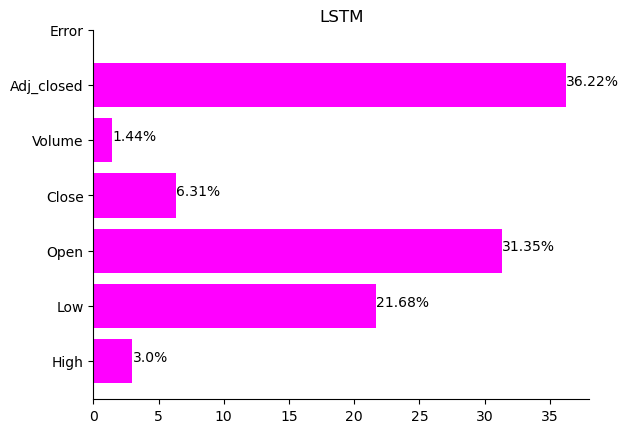

In [31]:
features = Test_df2.columns
epochs = 10
X = []
Y = []
Combo_Error_all =[]
for feature in range(len(features)):
    print(feature)
    for i in range(epochs):
        #print("combo: ",combo)
        Combined = Test_df2.copy()
        Permuted_DF = Permute(Test_df2,6)
        #for each feature in list, change the features to the permuted
        Combined.iloc[:,feature] = Permuted_DF.iloc[:,feature]
        #create a dataset
        Permute_Dataset = Permuted_Data(Original_Data=Test_df2, Permuted_data= Combined,window =hyper_params['sequence_length'])
        P_loader = DataLoader(dataset=Permute_Dataset,batch_size=len(Permute_Dataset),shuffle=False,num_workers=0)
        #test the permuted accuracy against the unpermuted 
        for k, (test_sequence, test_forecast) in enumerate(P_loader): 
                test_sequence = Variable(test_sequence).to(device)
                test_forecast = Variable(test_forecast).to(device)

                Permute_out = model(test_sequence)
                Predicted_Per = to_raw(Results=Permute_out, Data= "Test")
                Per_SMAPE = SMAPE(Actual=Predicted,Predicted=Predicted_Per)
        #create OHE dataset for which columns are permuted
        OHE = [0,0,0,0,0,0]
        OHE[feature] = 1
        X.append(OHE)
        Y.append(Per_SMAPE)


#create DF
Permuted_df2 = pd.concat([pd.DataFrame(X),pd.DataFrame(Y)],axis=1, join="inner")
Permuted_df2.columns = ["High","Low","Open","Close","Volume","Adj_closed","Error"]
y2, x2 = dmatrices('Error ~ High + Low + Open + Close + Volume + Adj_closed -1' , data=Permuted_df2, return_type='dataframe')

#fit a linear regression to one hot encoded data
mod = sm.OLS(y2, x2)    
res = mod.fit()       
importance = res.params
#Plot feature importance
# summarize feature importance
# plot feature importance
plt.rcdefaults()
fig5, ax = plt.subplots()
features = Permuted_df2.columns
ax.barh([x for x in range(len(importance))], 100*(importance/np.sum(importance)),color='fuchsia')
y = np.arange(len(features))
ax.set_yticks(y)
ax.set_yticklabels(features)
ax.set_title('LSTM')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
values = list(round(100*(importance/np.sum(importance)),2))
for i, v in enumerate(values):
    ax.text(v, i, str(v)+'%', 
            color = 'Black')
            
fig5.savefig('Results\LSTM_Permutation.pdf',dpi=900)
print("Finished Permutation")
